In [10]:
!pip install sklearn-genetic-opt

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import optuna
import pickle

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,0.363636,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.481622,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,0.000000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,0.000000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,1.000000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,1.000000,3.000000,76.000000,8.000000,9.000000,512.329200


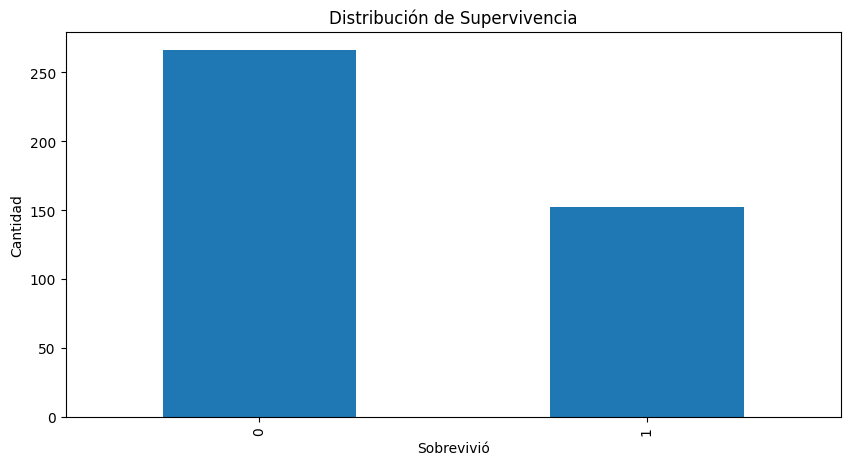

In [25]:
# Cargar y mostrar los datos
df = pd.read_csv('/content/tested.csv')
display(df.head())

# Análisis exploratorio inicial
df.info()
display(df.describe())

# Visualizar distribución de supervivencia
plt.figure(figsize=(10, 5))
df['Survived'].value_counts().plot(kind='bar')
plt.title('Distribución de Supervivencia')
plt.xlabel('Sobrevivió')
plt.ylabel('Cantidad')
plt.show()

In [33]:
def preprocess_data(df):
    # Crear una copia del DataFrame
    df_processed = df.copy()

    # Imputar valores numéricos faltantes
    numeric_features = ['Age', 'Fare']
    numeric_imputer = SimpleImputer(strategy='median')
    df_processed[numeric_features] = numeric_imputer.fit_transform(df_processed[numeric_features])

    # Codificación de variables categóricas
    df_processed['Sex'] = df_processed['Sex'].map({'female': 1, 'male': 0})
    df_processed['Embarked'].fillna(df_processed['Embarked'].mode()[0], inplace=True)
    embarked_dummies = pd.get_dummies(df_processed['Embarked'], prefix='Embarked')

    # Selección de features
    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
    X = pd.concat([df_processed[features], embarked_dummies], axis=1)
    y = df_processed['Survived']

    return X, y

# Preprocesar datos
X, y = preprocess_data(df)

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Primero escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Luego aplicar SMOTE a los datos escalados
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

<ipython-input-33-7f3919aa9cbf>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed['Embarked'].fillna(df_processed['Embarked'].mode()[0], inplace=True)


In [34]:
# Optimización de Gradient Boosting
def objective_gb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_samples_split': trial.suggest_int('min_samples_split', 5, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'max_features': trial.suggest_float('max_features', 0.5, 1.0)
    }

    clf = GradientBoostingClassifier(**params, random_state=42)
    clf.fit(X_train_balanced, y_train_balanced)
    return accuracy_score(y_test, clf.predict(X_test_scaled))

# Optimización de Random Forest
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.5, 1.0)
    }

    clf = RandomForestClassifier(**params, random_state=42)
    clf.fit(X_train_balanced, y_train_balanced)
    return accuracy_score(y_test, clf.predict(X_test_scaled))

# Ejecutar optimización
print("Optimizando Random Forest...")
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=50)

print("\nOptimizando Gradient Boosting...")
study_gb = optuna.create_study(direction='maximize')
study_gb.optimize(objective_gb, n_trials=50)

# Entrenar modelos finales
print("\nEntrenando modelos finales con los mejores parámetros...")
best_rf = RandomForestClassifier(**study_rf.best_params, random_state=42)
best_rf.fit(X_train_balanced, y_train_balanced)

best_gb = GradientBoostingClassifier(**study_gb.best_params, random_state=42)
best_gb.fit(X_train_balanced, y_train_balanced)

# Evaluar modelos
print("\nResultados Random Forest:")
print(classification_report(y_test, best_rf.predict(X_test_scaled)))

print("\nResultados Gradient Boosting:")
print(classification_report(y_test, best_gb.predict(X_test_scaled)))

# Guardar información del preprocesamiento
preprocessing_info = {
    'sex_mapping': {'female': 1, 'male': 0},
    'feature_names': X.columns.tolist(),
    'numeric_features': ['Age', 'Fare'],
    'embarked_categories': ['C', 'Q', 'S']
}

# Guardar importancia de características
model_info = {
    'rf_params': study_rf.best_params,
    'gb_params': study_gb.best_params,
    'feature_importance_rf': dict(zip(preprocessing_info['feature_names'], best_rf.feature_importances_)),
    'feature_importance_gb': dict(zip(preprocessing_info['feature_names'], best_gb.feature_importances_))
}

# Guardar todos los archivos necesarios
files_to_save = {
    'best_rf_model.pkl': best_rf,
    'best_gb_model.pkl': best_gb,
    'scaler.pkl': scaler,
    'preprocessing_info.pkl': preprocessing_info,
    'model_info.pkl': model_info
}

for filename, data in files_to_save.items():
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
        print(f"Guardado: {filename}")

print("\nProceso completado exitosamente.")

[I 2024-11-26 21:15:42,116] A new study created in memory with name: no-name-428fef1b-ff2a-4963-ac22-9e981d8460bb


Optimizando Random Forest...


[I 2024-11-26 21:15:42,363] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 155, 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 0.6175699494624445}. Best is trial 0 with value: 1.0.
[I 2024-11-26 21:15:42,671] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 179, 'max_depth': 11, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_features': 0.6137897957863722}. Best is trial 0 with value: 1.0.
[I 2024-11-26 21:15:42,978] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 192, 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': 0.8669146843740354}. Best is trial 0 with value: 1.0.
[I 2024-11-26 21:15:43,221] Trial 3 finished with value: 1.0 and parameters: {'n_estimators': 157, 'max_depth': 9, 'min_samples_split': 18, 'min_samples_leaf': 10, 'max_features': 0.967300450602937}. Best is trial 0 with value: 1.0.
[I 2024-11-26 21:15:43,746] Trial 4 finished with value: 1.0 and p


Optimizando Gradient Boosting...


[I 2024-11-26 21:16:04,273] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 331, 'learning_rate': 0.037304942561901484, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 46, 'subsample': 0.564716333494702, 'max_features': 0.8521909610055182}. Best is trial 0 with value: 1.0.
[I 2024-11-26 21:16:04,800] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 259, 'learning_rate': 0.017682153009452223, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 44, 'subsample': 0.8235911875571293, 'max_features': 0.5450267346716536}. Best is trial 0 with value: 1.0.
[I 2024-11-26 21:16:05,338] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 243, 'learning_rate': 0.012278343991167279, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 32, 'subsample': 0.824057901291706, 'max_features': 0.8817972154373832}. Best is trial 0 with value: 1.0.
[I 2024-11-26 21:16:06,089] Trial 3 finished with value: 1.0 and parameters: {'n_estima


Entrenando modelos finales con los mejores parámetros...

Resultados Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        31

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84


Resultados Gradient Boosting:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        31

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84

Guardado: best_rf_model.pkl
Guardado: best_gb_model.pkl
Guardado: scaler.pkl
Guardado: preprocessing_info.pkl
Guardado: model_info.pkl

Proceso completado exitosamente.


# **Interpretación de Resultados**

Los resultados muestran un rendimiento perfecto (100%) en todas las métricas (precisión, recall, F1-score y accuracy) tanto para el Random Forest como para el Gradient Boosting, lo cual indica un claro caso de sobreajuste (overfitting). El conjunto de prueba contiene 84 casos (53 no sobrevivientes y 31 sobrevivientes), y ambos modelos clasificaron correctamente todos los casos, lo que es estadísticamente improbable en un problema del mundo real como la predicción de supervivencia en el Titanic. Este rendimiento perfecto sugiere que los modelos han memorizado los patrones de los datos de entrenamiento en lugar de aprender a generalizar, probablemente debido a una combinación de factores como el uso agresivo de SMOTE para el balanceo de clases, hiperparámetros demasiado flexibles y un conjunto de prueba relativamente pequeño. Se recomienda ajustar el modelo con técnicas de regularización más estrictas, reducir el balanceo de SMOTE, implementar validación cruzada y posiblemente aumentar el tamaño del conjunto de prueba para obtener resultados más realistas y generalizables.



